In [278]:
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from nltk.translate.bleu_score import sentence_bleu


import spacy

import random
import math
import os


SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")


print(vars(train_data.examples[0]))

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


In [279]:
BATCH_SIZE = 1
Attention_vis = []


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

cpu


In [280]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        
        self.linear = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, input):
        
        # input dim => (src_sent_len, batch_size)
        embed = self.dropout(self.embedding(input))
        
        # embed dim => (src_sent_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embed)
        
        # outputs dim => (src_sent_len, batch size, enc_hid_dim * num directions)
        # hidden dim => (number of layers * number of directions, batch size, enc_hid_dim)
        
        hidden = torch.tanh(self.linear(torch.cat((hidden[-2, : , :], hidden[-1, :, :]), dim = 1)))
        
        # hidden[-2, :, :] reduces 3d to 2d tensor since first dimension is now fixed, so dim = 1 is the last dimension
        # hidden dim => (batch size, dec_hid_dim)
        
        return outputs, hidden

In [281]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear(enc_hid_dim * 2 + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.randn(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs):
        
        # hidden should be => (number of layers * number of directions, batch size, dec_hid_dim))
        # but the author did a squeeze operation in the decoder before returning the last hidden state
        # so hidden dimension becomes => (batch size, dec_hid_dim)
        # another reason to do this would be keep hidden dim similar in both encoder and decoder
        
        # hidden dimension becomes => (batch size, dec_hid_dim)
        # encoder_outputs dimension => (src_sent_len, batch size, enc_hid_dim * num directions)
        
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len,1)
        # hidden new dim = > (batch_size, src_len, dec_hid_dim) 
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs new dim = > (batch_size, src_len, enc_hid_dim * 2) 
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        
        # attn dim = > (batch_size, src_len, dec_hid_dim)
        energy = energy.permute(0, 2, 1)
        
        # we want to compute energy whose dimension is => (batch size, dec_hid_dim, source sent len)
        
        # v dim should be => (batch_size, 1, dec-hid_dim)
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        # attention dim (batch_size, 1, src_len)
        # torch.bmm(batch1, batch2, out=None) → Tensor
        # If batch1 is a (b×n×m) tensor, batch2 is a (b×m×p) tensor, out will be a (b×n×p) tensor
        attention = torch.bmm(v, energy).squeeze(1)
        
        # attention dim (batch_size, src_len)
#         print("attention")
#         print(F.softmax(attention, dim=1))
        Attention_vis.append(list(F.softmax(attention, dim=1)[0].numpy()))
        return F.softmax(attention, dim=1)

In [282]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim * 2 + emb_dim, dec_hid_dim)
        self.fc = nn.Linear(enc_hid_dim * 2 + emb_dim + dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, encoder_outputs, hidden):
        
        # input dim => [batch_size]
        # encoder_outputs = [src sent len, batch size, enc hid dim * 2]
#         print("decoder input 1")
#         print(input)
        input = input.unsqueeze(0)
        # input dim => [1, batch_size]
#         print("decoder input 2")
#         print(input)


        embed = self.dropout(self.embedding(input))
#         print("decoder input 3")
        

        # embed dimension => (1, batch_size, emb_dim)
        
        a = self.attention(hidden, encoder_outputs)
        # a dim => (batch_size, src_len)
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        a = a.unsqueeze(1)
        # a dim => (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # a dim => (batch_size, 1, src_len)
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        # weighted dim => (batch_size, 1, enc_hid_dim * 2)
        weighted = weighted.permute(1, 0, 2)
        # weighted dim => (1, batch_size, enc_hid_dim * 2)

        rnn_input = torch.cat((weighted, embed), dim=2)
        #hidden = [batch size, dec hid dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        # outputs dim => (src_sent_len, batch size, enc_hid_dim * num directions)
        # hidden dim => (number of layers * number of directions, batch size, enc_hid_dim)
        
        # here src_sent_len = number of layers = number of directions = 1 for decoder only
        # sp basically
        # outputs dim => (1, batch size, enc_hid_dim * num directions)
        # hidden dim => (1, batch size, enc_hid_dim)
        
        
        prediction = self.fc(torch.cat((output.squeeze(0), weighted.squeeze(0), embed.squeeze(0)), dim=1))
        return prediction, hidden.squeeze(0)

In [283]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [sent len, batch size]
        #trg = [sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
#         print("trg shape", trg.shape)
        trg_vocab_size = self.decoder.output_dim
#         print("batch size ", batch_size)
#         print("max len ", max_len)
#         print("trg vocab size ", trg_vocab_size)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
#         print("shape of outputs")
#         print(outputs.shape)
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, hidden = self.encoder(src)
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
#         print("first input")
#         print(output)
        for t in range(1, max_len):
#             print("in LOOP")
            output, hidden = self.decoder(output, encoder_outputs, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
#             print("output in loop")
#             print(output)
#             print(output.max(1))
            top1 = output.max(1)[1] # index of the max value
            output = (trg[t] if teacher_force else top1)
        
        return outputs

In [284]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())

pad_idx = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)


In [285]:
# def train(model, iterator, optimizer, criterion, clip):
    
#     model.train()
    
#     epoch_loss = 0
    
#     for i, batch in enumerate(iterator):
#         print("train iterator ", i)
#         src = batch.src
#         trg = batch.trg
# #         print("src")
# #         print(src)
# #         print("target")
# #         print(trg)
#         optimizer.zero_grad()
        
#         output = model(src, trg)
# #         print("output after seq2seq")
# #         print(output)
# #         print(output.shape)
#         #trg = [sent len, batch size]
#         #output = [sent len, batch size, output dim]
        
#         #reshape to:
#         #trg = [(sent len - 1) * batch size]
#         #output = [(sent len - 1) * batch size, output dim]
#         x = output[1:].view(-1, output.shape[2])
#         y = trg[1:].view(-1)
# #         print("X ", x.shape)
# #         print(x[0])
# #         print("Y ", y.shape)
# #         print(y)
#         loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))
        
#         loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
#         optimizer.step()
        
#         epoch_loss += loss.item()
        
        
#     return epoch_loss / len(iterator)

In [286]:
def process_final(t):
    sentences = []
    for i in range(len(t[0])):
        tensor_out = t[:, i]
        tensor_out = list(tensor_out.numpy())
        sentence = []
        for j in tensor_out:
            if TRG.vocab.itos[j] == '<pad>':
                break
            if TRG.vocab.itos[j] == '<eos>':
                sentence.append(TRG.vocab.itos[j])
                break
            sentence.append(TRG.vocab.itos[j])
        sentences.append(sentence)
    return sentences


def process_source(t):
    sentences = []
    for i in range(len(t[0])):
        tensor_out = t[:, i]
        tensor_out = list(tensor_out.numpy())
        sentence = []
        for j in tensor_out:
            if SRC.vocab.itos[j] == '<pad>':
                break
            if SRC.vocab.itos[j] == '<eos>':
                sentence.append(SRC.vocab.itos[j])
                break
            sentence.append(SRC.vocab.itos[j])
        sentences.append(sentence)
    return sentences


def process_output(output):
    y = []
    for elem in output:
        x = []
        z = []
        for arr in elem:
            values, indices = arr.max(0)
            x.append(indices.item())
            z.append(values.item())
#         print("printing x")
#         print(x)
#         print("printing z")
#         print(z)


        y.append(x)
    final_tensor = torch.tensor(y)
    print("final tensor ")
    print(final_tensor)
    return process_final(final_tensor)

In [287]:
def evaluate(model, iterator, criterion, testing):
    global Attention_vis
    model.eval()
    
    epoch_loss = 0
    bleu_score = 0
    count_pair = 0
    exclude = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            exclude += 1
            if exclude < 21:
                continue
            src = batch.src
            trg = batch.trg
            print("batch src")
            print(src)
            
            source_sent = process_source(src)
            print(source_sent)
            output = model(src, trg, 0) #turn off teacher forcing
            if testing:
                output_a = output[1:]
                trg_a = trg[1:]

                sent_out = process_output(output_a)
                sent_trg = process_final(trg_a)
                for o, t in zip(sent_out, sent_trg):
                    reference = [t]
                    candidate = o
                    print("reference ")
                    print(reference)
                    print("candidate ")
                    print(candidate)
                    bleu_score += sentence_bleu(reference, candidate)
                    count_pair += 1
            x = output[1:].view(-1, output.shape[2])
            y = trg[1:].view(-1)
            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))

            epoch_loss += loss.item()
            showAttention(source_sent[0], candidate, Attention_vis)
            Attention_vis = []
            if testing and count_pair == 10:
                break
        if testing:
            print("count pair ", count_pair)
            print("bleu score ")


            print(bleu_score / count_pair)
#     print("attention vis")
#     print(Attention_vis)
    
    return epoch_loss / len(iterator), source_sent[0], candidate


In [288]:
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'seq2seq_attention.pt')


# N_EPOCHS = 10
# CLIP = 1
# SAVE_DIR = 'models'
# MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'seq2seq_attention_en_de.pt')

# best_valid_loss = float('inf')

# if not os.path.isdir(f'{SAVE_DIR}'):
#     os.makedirs(f'{SAVE_DIR}')

# for epoch in range(N_EPOCHS):
#     print("epoch ", epoch)
#     train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, valid_iterator, criterion, False)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
#     print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')
#     print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}  |')

In [289]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


#source sentence should be at x axis tick
def showAttention(input_sentence, output_sentence, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    print(input_sentence)
    print(output_sentence)


    x = list(input_sentence)
    ax.set_xticks(np.arange(len(x)))

    ax.set_xticklabels([" "] + x, rotation = 90)

    y = list(output_sentence)
    ax.set_yticks(np.arange(len(y)))

    ax.set_yticklabels([" "] + y)


#     x = [50, 60, 70]
#     pos = np.arange(len(x))
#     ax.set_xticks(pos)
#     ax.set_xticklabels(x, rotation=90, ha="center")

    # Set up axes

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
# e = [[500., 500.,500.], [4.,5.,6.], [7.,8.,9.], [11.,500.,13.]]
# # e = torch.Tensor(e)

# showAttention([1], [2], e)

batch src
tensor([[  2],
        [  5],
        [177],
        [ 25],
        [350],
        [  7],
        [  6],
        [449],
        [  3]])
[['<sos>', 'ein', 'junges', 'mädchen', 'schwimmt', 'in', 'einem', 'pool', '<eos>']]
final tensor 
tensor([[  4],
        [ 24],
        [ 33],
        [256],
        [  6],
        [  4],
        [162],
        [162]])
reference 
[['a', 'young', 'girl', 'swimming', 'in', 'a', 'pool', '<eos>']]
candidate 
['a', 'young', 'girl', 'swimming', 'in', 'a', 'pool', 'pool']
['<sos>', 'ein', 'junges', 'mädchen', 'schwimmt', 'in', 'einem', 'pool', '<eos>']
['a', 'young', 'girl', 'swimming', 'in', 'a', 'pool', 'pool']


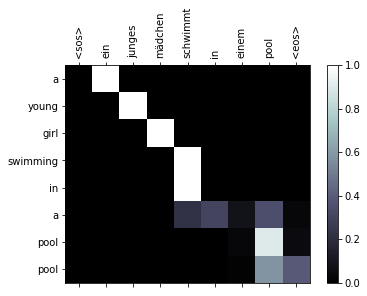

batch src
tensor([[  2],
        [ 18],
        [121],
        [ 57],
        [ 21],
        [  6],
        [224],
        [  4],
        [  3]])
[['<sos>', 'zwei', 'hunde', 'spielen', 'an', 'einem', 'baum', '.', '<eos>']]
final tensor 
tensor([[ 16],
        [112],
        [ 17],
        [ 37],
        [  4],
        [159],
        [  5],
        [  3]])
reference 
[['two', 'dogs', 'play', 'by', 'a', 'tree', '.', '<eos>']]
candidate 
['two', 'dogs', 'are', 'playing', 'a', 'tree', '.', '<eos>']
['<sos>', 'zwei', 'hunde', 'spielen', 'an', 'einem', 'baum', '.', '<eos>']
['two', 'dogs', 'are', 'playing', 'a', 'tree', '.', '<eos>']


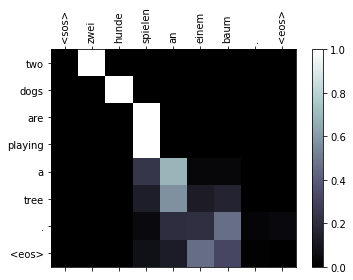

batch src
tensor([[  2],
        [  5],
        [ 70],
        [114],
        [ 32],
        [ 69],
        [ 42],
        [  0],
        [  3]])
[['<sos>', 'ein', 'kleiner', 'schwarzer', 'hund', 'springt', 'über', '<unk>', '<eos>']]
final tensor 
tensor([[  4],
        [ 70],
        [ 26],
        [ 35],
        [179],
        [ 76],
        [ 76],
        [  0]])
reference 
[['a', 'small', 'black', 'dog', 'jumping', 'over', 'gates', '<eos>']]
candidate 
['a', 'small', 'black', 'dog', 'jumps', 'over', 'over', '<unk>']
['<sos>', 'ein', 'kleiner', 'schwarzer', 'hund', 'springt', 'über', '<unk>', '<eos>']
['a', 'small', 'black', 'dog', 'jumps', 'over', 'over', '<unk>']


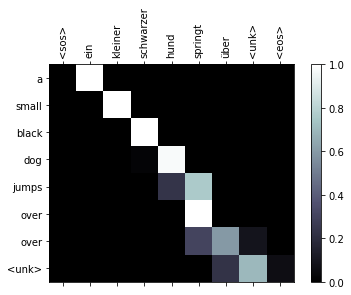

batch src
tensor([[  2],
        [ 18],
        [103],
        [ 65],
        [ 12],
        [ 24],
        [222],
        [  4],
        [  3]])
[['<sos>', 'zwei', 'kleine', 'kinder', 'auf', 'dem', 'sand', '.', '<eos>']]
final tensor 
tensor([[ 16],
        [ 70],
        [ 63],
        [ 17],
        [  8],
        [211],
        [211],
        [211]])
reference 
[['two', 'young', 'children', 'are', 'on', 'sand', '.', '<eos>']]
candidate 
['two', 'small', 'children', 'are', 'on', 'sand', 'sand', 'sand']
['<sos>', 'zwei', 'kleine', 'kinder', 'auf', 'dem', 'sand', '.', '<eos>']
['two', 'small', 'children', 'are', 'on', 'sand', 'sand', 'sand']


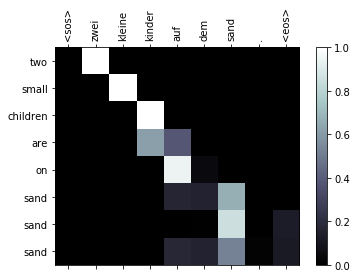

batch src
tensor([[   2],
        [  18],
        [1257],
        [  10],
        [   8],
        [  16],
        [ 302],
        [   4],
        [   3]])
[['<sos>', 'zwei', 'typen', 'und', 'eine', 'frau', 'lächeln', '.', '<eos>']]
final tensor 
tensor([[ 16],
        [360],
        [ 11],
        [  4],
        [ 14],
        [527],
        [133],
        [  5]])
reference 
[['two', 'guys', 'and', 'a', 'girl', 'smiling', '.', '<eos>']]
candidate 
['two', 'guys', 'and', 'a', 'woman', 'smile', 'smiling', '.']
['<sos>', 'zwei', 'typen', 'und', 'eine', 'frau', 'lächeln', '.', '<eos>']
['two', 'guys', 'and', 'a', 'woman', 'smile', 'smiling', '.']


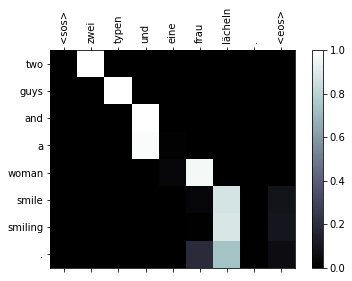

batch src
tensor([[  2],
        [ 18],
        [ 30],
        [ 53],
        [  7],
        [  6],
        [239],
        [  4],
        [  3]])
[['<sos>', 'zwei', 'männer', 'sitzen', 'in', 'einem', 'restaurant', '.', '<eos>']]
final tensor 
tensor([[ 16],
        [ 30],
        [ 17],
        [ 32],
        [ 20],
        [  4],
        [235],
        [  5]])
reference 
[['two', 'men', 'sitting', 'in', 'a', 'restaurant', '.', '<eos>']]
candidate 
['two', 'men', 'are', 'sitting', 'at', 'a', 'restaurant', '.']
['<sos>', 'zwei', 'männer', 'sitzen', 'in', 'einem', 'restaurant', '.', '<eos>']
['two', 'men', 'are', 'sitting', 'at', 'a', 'restaurant', '.']


/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


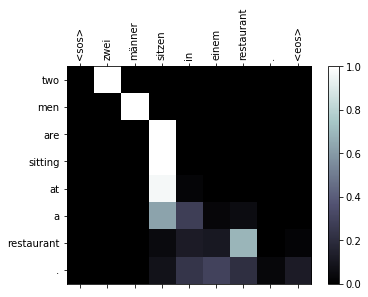

batch src
tensor([[ 2],
        [ 5],
        [26],
        [29],
        [11],
        [43],
        [25],
        [ 4],
        [ 3]])
[['<sos>', 'ein', 'junge', 'steht', 'mit', 'drei', 'mädchen', '.', '<eos>']]
final tensor 
tensor([[  4],
        [ 34],
        [ 89],
        [ 13],
        [ 48],
        [ 48],
        [104],
        [  5]])
reference 
[['a', 'boy', 'stands', 'with', 'three', 'girls', '.', '<eos>']]
candidate 
['a', 'boy', 'stands', 'with', 'three', 'three', 'girls', '.']
['<sos>', 'ein', 'junge', 'steht', 'mit', 'drei', 'mädchen', '.', '<eos>']
['a', 'boy', 'stands', 'with', 'three', 'three', 'girls', '.']


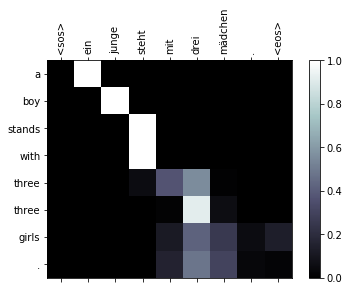

batch src
tensor([[   2],
        [  73],
        [3150],
        [   5],
        [1290],
        [   4],
        [   3]])
[['<sos>', 'leute', 'bewundern', 'ein', 'kunstwerk', '.', '<eos>']]
final tensor 
tensor([[ 19],
        [ 17],
        [  4],
        [  4],
        [511],
        [  5],
        [  3],
        [  3],
        [  3]])
reference 
[['people', 'are', 'admiring', 'a', 'work', 'of', 'art', '.', '<eos>']]
candidate 
['people', 'are', 'a', 'a', 'art', '.', '<eos>']
['<sos>', 'leute', 'bewundern', 'ein', 'kunstwerk', '.', '<eos>']
['people', 'are', 'a', 'a', 'art', '.', '<eos>']


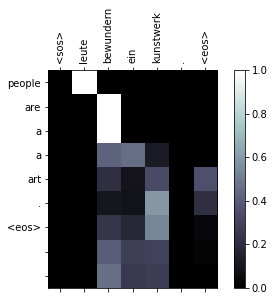

batch src
tensor([[   2],
        [   5],
        [ 734],
        [  32],
        [  83],
        [5612],
        [   4],
        [   3]])
[['<sos>', 'ein', 'hellbrauner', 'hund', 'läuft', 'bergauf', '.', '<eos>']]
final tensor 
tensor([[  4],
        [282],
        [ 35],
        [ 79],
        [ 79],
        [  5],
        [  3],
        [  3],
        [  3]])
reference 
[['a', 'light', 'brown', 'dog', 'is', 'running', 'up', '.', '<eos>']]
candidate 
['a', 'tan', 'dog', 'running', 'running', '.', '<eos>']


/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


['<sos>', 'ein', 'hellbrauner', 'hund', 'läuft', 'bergauf', '.', '<eos>']
['a', 'tan', 'dog', 'running', 'running', '.', '<eos>']


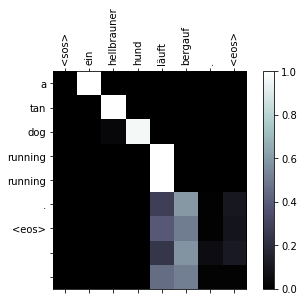

batch src
tensor([[   2],
        [  18],
        [3746],
        [  12],
        [  24],
        [ 135],
        [   4],
        [   3]])
[['<sos>', 'zwei', 'fußballmannschaften', 'auf', 'dem', 'feld', '.', '<eos>']]
final tensor 
tensor([[ 16],
        [123],
        [215],
        [  8],
        [  7],
        [ 85],
        [ 85],
        [  5],
        [  3]])
reference 
[['two', 'soccer', 'teams', 'are', 'on', 'the', 'field', '.', '<eos>']]
candidate 
['two', 'soccer', 'players', 'on', 'the', 'field', 'field', '.', '<eos>']
['<sos>', 'zwei', 'fußballmannschaften', 'auf', 'dem', 'feld', '.', '<eos>']
['two', 'soccer', 'players', 'on', 'the', 'field', 'field', '.', '<eos>']


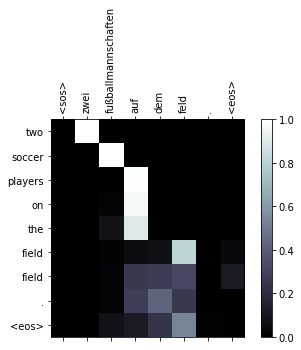

count pair  10
bleu score 
0.30630143997402004
| Test Loss: 0.020 | Test PPL:   1.020 |


In [290]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test_loss, src_sent, trg_sent = evaluate(model, test_iterator, criterion, True)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

